# Úloha 1 – Výpočet tepové frekvence z EKG signálu

Cílem této úlohy je navrhnout algoritmus, který automaticky detekuje
R-vrcholy v EKG signálu a na základě jejich počtu vypočítá
tepovou frekvenci (BPM).

Data pocházejí z databáze PhysioNet (drivedb), která obsahuje
celkem 17 měření EKG signálu. Signály jsou načteny lokálně.

Knihovna WFDB je použita pouze pro načtení dat ze souborů.
Samotné zpracování a detekce R-vrcholů je realizována
vlastním algoritmem.


In [9]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os

## Struktura vstupních dat

Vstupní data jsou uložena ve složce `data/`.

Každé měření je tvořeno dvojicí souborů:
- `.dat` – obsahuje samotná naměřená data EKG signálu,
- `.hea` – obsahuje hlavičku s metadaty (např. vzorkovací frekvenci a počet kanálů).

Soubor `RECORDS` obsahuje seznam všech dostupných měření v databázi
a slouží k jejich automatickému načtení.


In [10]:
slozka_dat = "data"

## Načtení seznamu měření

Seznam dostupných EKG záznamů je uložen v souboru `RECORDS`.
Každý řádek tohoto souboru obsahuje název jednoho měření.

Načtením tohoto souboru je možné automaticky zpracovat
všechna dostupná měření bez nutnosti jejich ručního vypisování.


In [11]:
cesta_records = os.path.join(slozka_dat, "RECORDS")

with open(cesta_records, "r") as f:
    zaznamy = []
    for radek in f:
        zaznamy.append(radek.strip())

zaznamy


['drive01',
 'drive02',
 'drive03',
 'drive04',
 'drive05',
 'drive06',
 'drive07',
 'drive08',
 'drive09',
 'drive10',
 'drive11',
 'drive12',
 'drive13',
 'drive14',
 'drive15',
 'drive16',
 'drive17a',
 'drive17b']

Poznamka: V databazi je celkem 17 mereni. Posledni mereni je rozdeleno na `drive17a` a `drive17b`.


## Detekce R-vrcholů

Detekce R-vrcholů je založena na následujícím postupu:

- použití absolutní hodnoty signálu (umožňuje detekovat i záporné vrcholy),
- stanovení adaptivního prahu na základě průměru a směrodatné odchylky,
- výběr lokálního maxima po překročení prahu,
- omezení minimální vzdálenosti mezi vrcholy (cca 300 ms),
  aby nedocházelo k vícenásobné detekci jednoho tepu.

Tento postup umožňuje robustní detekci dominantních vrcholů
i při přítomnosti šumu v signálu.


## Grafické schéma algoritmu

EKG signál  
↓  
Absolutní hodnota signálu  
↓  
Adaptivní prahování (μ + k·σ)  
↓  
Výběr kandidátů nad prahem  
↓  
Detekce lokálních maxim  
↓  
Omezení minimální vzdálenosti  
↓  
Seznam R-vrcholů  
↓  
Výpočet BPM


In [12]:
def detekuj_r_vrcholy(ekg, fs, koef_prah=2.5, min_ms=300):
    # prevedeni na numpy pole
    ekg = np.asarray(ekg)

    # absolutni hodnota signalu (zachyti i zaporne vrcholy)
    ekg_abs = np.abs(ekg)

    # vypocet adaptivniho prahu
    prah = np.mean(ekg_abs) + koef_prah * np.std(ekg_abs)

    # minimalni vzdalenost mezi vrcholy (v poctu vzorku)
    min_vzd = int((min_ms / 1000) * fs)

    # indexy vzorku nad prahem
    kandidati = np.where(ekg_abs > prah)[0]

    if len(kandidati) == 0:
        return np.array([])

    r_vrcholy = []
    posledni_vrchol = -min_vzd
    i = 0

    while i < len(kandidati):
        idx = kandidati[i]

        # pokud je kandidat prilis blizko predchozimu vrcholu, preskoc
        if idx - posledni_vrchol < min_vzd:
            i += 1
            continue

        # vyhledani lokalniho maxima v danem useku
        start = idx
        konec = min(idx + min_vzd, len(ekg_abs))

        vrchol = start + np.argmax(ekg_abs[start:konec])

        r_vrcholy.append(vrchol)
        posledni_vrchol = vrchol

        # preskoc dalsi kandidaty v ramci tohoto useku
        while i < len(kandidati) and kandidati[i] < konec:
            i += 1

    return np.array(r_vrcholy)


## Výpočet tepové frekvence

Tepová frekvence (BPM – beats per minute) je definována jako
počet srdečních tepů za jednu minutu.

Vzhledem k tomu, že délka záznamu není přesně jedna minuta,
je nejprve vypočítána skutečná délka signálu v minutách:

délka záznamu = počet vzorků / vzorkovací frekvence / 60

Tepová frekvence je následně určena jako:

BPM = počet detekovaných R-vrcholů / délka záznamu v minutách


In [13]:
vysledky_bpm = {}

for zaznam in zaznamy:
    record = wfdb.rdrecord(os.path.join(slozka_dat, zaznam))
    ekg = record.p_signal[:, 0]
    fs = record.fs

    r_vrcholy = detekuj_r_vrcholy(ekg, fs)

    # delka zaznamu v minutach
    delka_min = len(ekg) / fs / 60

    # vypocet BPM
    bpm = len(r_vrcholy) / delka_min

    vysledky_bpm[zaznam] = bpm

vysledky_bpm


{'drive01': 6.653766727914276,
 'drive02': 0.9174182638105974,
 'drive03': 70.83115391975505,
 'drive04': 8.694437888443082,
 'drive05': 13.742263963147753,
 'drive06': 22.803402420031148,
 'drive07': 3.214987506368113,
 'drive08': 0.22169542703518783,
 'drive09': 0.8748027673261319,
 'drive10': 7.60318552227749,
 'drive11': 21.066686084228085,
 'drive12': 48.98158095706538,
 'drive13': 3.64116200758993,
 'drive14': 3.64116200758993,
 'drive15': 35.070282097799435,
 'drive16': 3.7558343540004633,
 'drive17a': 4.787234042553191,
 'drive17b': 4.796448953709575}

## Tabulka vypočtených hodnot BPM

Následující tabulka shrnuje vypočtenou tepovou frekvenci
pro jednotlivá měření z databáze drivedb.

Tabulka obsahuje název měření a odpovídající hodnotu
průměrné tepové frekvence v jednotkách BPM.


In [14]:
import pandas as pd

tabulka_bpm = pd.DataFrame({
    "Mereni": list(vysledky_bpm.keys()),
    "Tepova frekvence [BPM]": list(vysledky_bpm.values())
})

tabulka_bpm


,Mereni,Tepova frekvence [BPM]
0,drive01,6.653767
1,drive02,0.917418
2,drive03,70.831154
3,drive04,8.694438
4,drive05,13.742264
5,drive06,22.803402
6,drive07,3.214988
7,drive08,0.221695
8,drive09,0.874803
9,drive10,7.603186


## Graf tepové frekvence

Následující graf znázorňuje vypočtenou průměrnou
tepovou frekvenci pro jednotlivá měření
z databáze drivedb.

Graf umožňuje vizuální porovnání hodnot
mezi jednotlivými jízdami.


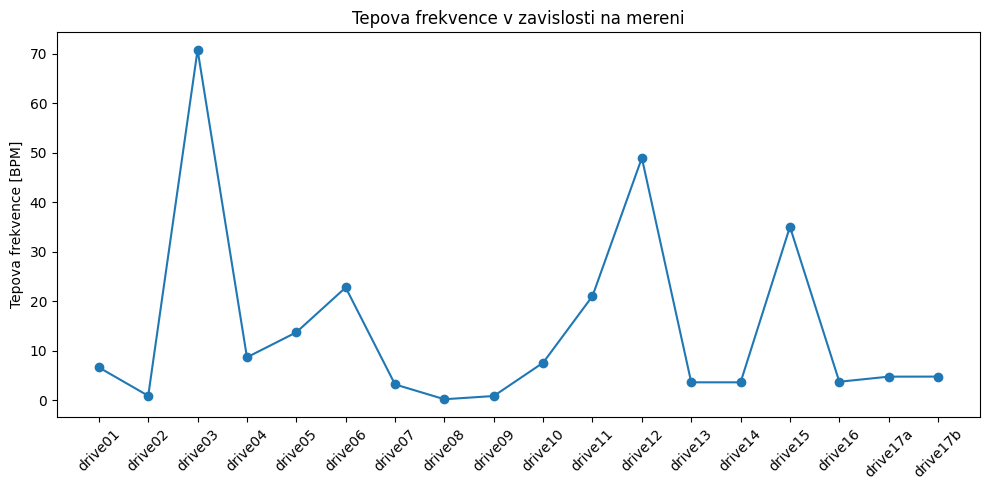

In [15]:
nazvy = list(vysledky_bpm.keys())
bpm_hodnoty = list(vysledky_bpm.values())

plt.figure(figsize=(10,5))
plt.plot(nazvy, bpm_hodnoty, marker="o")
plt.xticks(rotation=45)
plt.ylabel("Tepova frekvence [BPM]")
plt.title("Tepova frekvence v zavislosti na mereni")
plt.tight_layout()
plt.show()


## Vizualizace EKG signálu s detekovanými R-vrcholy (zoom)

Celý záznam EKG je časově rozsáhlý, proto je pro přehlednost
zobrazen pouze krátký úsek signálu (např. 6 sekund).

V grafu jsou vyznačeny detekované R-vrcholy,
což umožňuje vizuální kontrolu správnosti algoritmu.


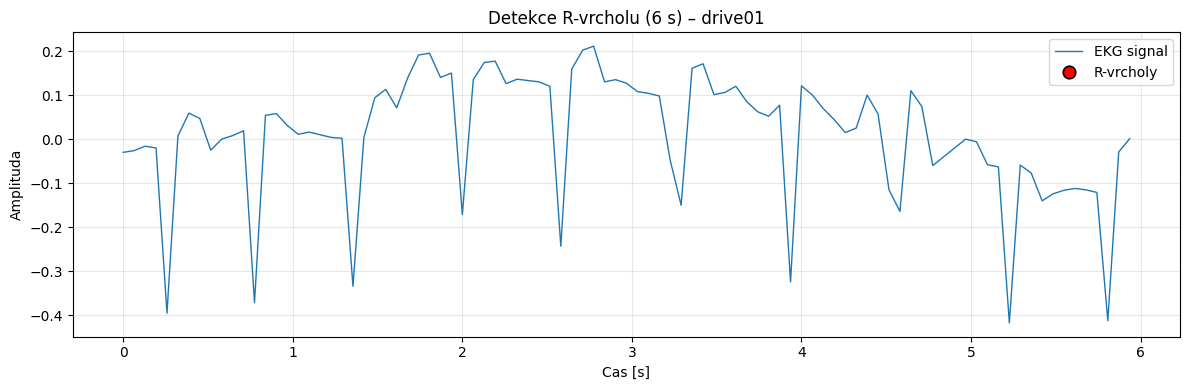

In [16]:
zaznam_test = zaznamy[0]  # napr. drive01

record = wfdb.rdrecord(os.path.join(slozka_dat, zaznam_test))
ekg = record.p_signal[:, 0]
fs = record.fs

r_vrcholy = detekuj_r_vrcholy(ekg, fs, koef_prah=2.2, min_ms=300)

sekundy = 6
vzorky = int(sekundy * fs)

cas = np.arange(vzorky) / fs
r_kratke = r_vrcholy[r_vrcholy < vzorky]

plt.figure(figsize=(12,4))
plt.plot(cas, ekg[:vzorky], label="EKG signal", linewidth=1)

plt.plot(
    cas[r_kratke],
    ekg[r_kratke],
    "o",
    markersize=9,
    markerfacecolor="red",
    markeredgecolor="black",
    markeredgewidth=1.2,
    label="R-vrcholy"
)

plt.xlabel("Cas [s]")
plt.ylabel("Amplituda")
plt.title(f"Detekce R-vrcholu ({sekundy} s) – {zaznam_test}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 4) Test algoritmu na databázi MIT-BIH

### Cíl

Cílem této části je ověřit správnost navrženého algoritmu
na anotované databázi MIT-BIH (nsrdb).

Postup testování:

- načtení EKG záznamu z disku,
- načtení referenčních anotací R-vrcholů (.atr),
- spuštění navrženého detekčního algoritmu,
- porovnání detekovaných vrcholů s anotacemi
  s použitím časové tolerance (např. 50 ms),
- vyhodnocení úspěšnosti pomocí metrik:
  TP, FP, FN, Precision, Recall a F1-score.

Toleranci používáme z důvodu, že detekce
nemusí odpovídat přesně stejnému vzorku jako anotace,
ale může se lišit o několik milisekund.

Knihovna WFDB je zde použita pouze pro načtení
signálu a anotací.


In [17]:
# slozka, kde mas soubory 16265.dat, 16265.hea, 16265.atr atd.
slozka_mitbih = "mit-bih"

# vezmeme par zaznamu na test (muzeš pridat dalsi)
test_zaznamy = ["16265", "16272", "16273"]

# maly check jestli soubory existuji
for rid in test_zaznamy:
    hea = os.path.join(slozka_mitbih, rid + ".hea")
    dat = os.path.join(slozka_mitbih, rid + ".dat")
    atr = os.path.join(slozka_mitbih, rid + ".atr")
    print(rid, "hea:", os.path.exists(hea), "dat:", os.path.exists(dat), "atr:", os.path.exists(atr))


16265 hea: True dat: True atr: True
16272 hea: True dat: True atr: True
16273 hea: True dat: True atr: True


### Porovnání detekce s anotacemi

Detekované vrcholy (r_pred) jsou porovnávány
s referenčními anotacemi (r_true).

Vrchol je považován za správně detekovaný (True Positive),
pokud se nachází v časové toleranci ±50 ms
od některé referenční anotace.

Každá anotace může být použita maximálně jednou,
aby nedošlo k vícenásobnému započítání stejného tepu.


In [18]:
def vyhodnot_detekci(r_pred, r_true, fs, tolerance_ms=50):
    # tolerance v poctu vzorku
    tolerance_vzorky = int((tolerance_ms / 1000) * fs)

    r_pred = np.asarray(r_pred, dtype=int)
    r_true = np.asarray(r_true, dtype=int)

    tp = 0
    pouzite_true_indexy = set()  # abych nepočítal jednu anotaci vicekrat

    # projdu vsechny moje detekce
    for p in r_pred:
        # najdu anotace, ktere jsou blizko (v toleranci)
        blizke = np.where(np.abs(r_true - p) <= tolerance_vzorky)[0]

        # kdyz nic blizko neni -> tohle bude FP
        if len(blizke) == 0:
            continue

        # vyberu prvni anotaci, ktera jeste nebyla pouzita
        for idx_true in blizke:
            if idx_true not in pouzite_true_indexy:
                tp += 1
                pouzite_true_indexy.add(idx_true)
                break

    fp = len(r_pred) - tp
    fn = len(r_true) - tp

    # metriky
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return tp, fp, fn, precision, recall, f1


### Spuštění testu na databázi MIT-BIH

Pro každý vybraný záznam je proveden následující postup:

1. Načtení EKG signálu.
2. Načtení referenčních anotací R-vrcholů (.atr).
3. Spuštění navrženého detekčního algoritmu.
4. Porovnání detekovaných vrcholů s anotacemi
   s tolerancí 50 ms.
5. Výpočet metrik TP, FP, FN, Precision, Recall a F1-score.

Výsledky jsou následně uloženy do tabulky.


In [19]:
vysledky_test = []

for rid in test_zaznamy:
    cesta = os.path.join(slozka_mitbih, rid)

    # 1) nacteni signalu
    rec = wfdb.rdrecord(cesta)
    ekg = rec.p_signal[:, 0]
    fs = rec.fs

    # 2) nacteni anotaci (R-vrcholy)
    ann = wfdb.rdann(cesta, "atr")
    r_true = ann.sample

    # 3) moje detekce
    r_pred = detekuj_r_vrcholy(ekg, fs, koef_prah=2.2, min_ms=300)

    # 4) vyhodnoceni
    tp, fp, fn, prec, reci, f1 = vyhodnot_detekci(r_pred, r_true, fs, tolerance_ms=50)

    vysledky_test.append({
        "Zaznam": rid,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": prec,
        "Recall": reci,
        "F1": f1
    })

df_test = pd.DataFrame(vysledky_test)
df_test


,Zaznam,TP,FP,FN,Precision,Recall,F1
0,16265,100468,18,487,0.999821,0.995176,0.997493
1,16272,25103,6684,72043,0.789725,0.258405,0.389396
2,16273,89826,79,271,0.999121,0.996992,0.998056


In [20]:
prumery = df_test[["Precision", "Recall", "F1"]].mean()
print("Prumerne metriky:")
print(prumery)


Prumerne metriky:
Precision    0.929556
Recall       0.750191
F1           0.794982
dtype: float64


## Graf metrik úspěšnosti (Precision, Recall, F1-score)

Následující graf znázorňuje hodnoty metrik
Precision, Recall a F1-score
pro jednotlivé testované záznamy databáze MIT-BIH.

Graf umožňuje vizuální porovnání výkonnosti
detekčního algoritmu napříč různými záznamy.


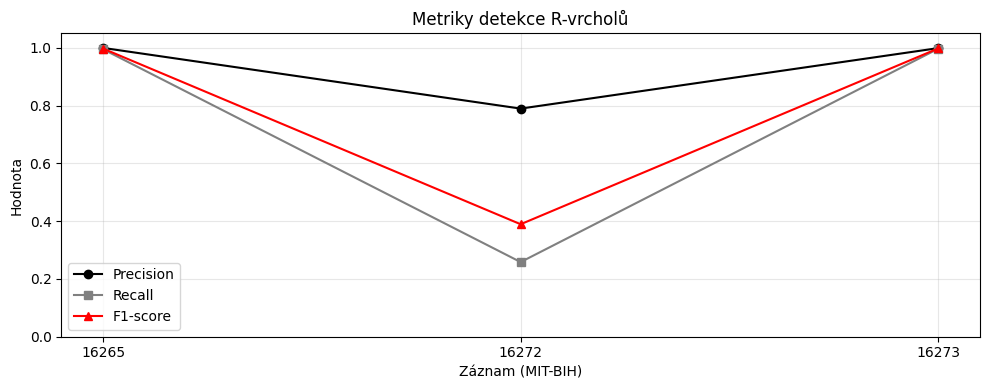

In [21]:
plt.figure(figsize=(10,4))

plt.plot(df_test["Zaznam"], df_test["Precision"], "o-", color="black", label="Precision")
plt.plot(df_test["Zaznam"], df_test["Recall"], "s-", color="gray", label="Recall")
plt.plot(df_test["Zaznam"], df_test["F1"], "^-", color="red", label="F1-score")

plt.ylim(0, 1.05)

plt.xlabel("Záznam (MIT-BIH)")
plt.ylabel("Hodnota")
plt.title("Metriky detekce R-vrcholů")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Závěr programové části

V rámci této práce byl navržen a implementován algoritmus
pro automatickou detekci R-vrcholů v EKG signálu.
Detekce je založena na adaptivním prahování
a výběru lokálních maxim s omezením minimální
vzdálenosti mezi jednotlivými tepy.

Na základě počtu detekovaných R-vrcholů
byla vypočítána tepová frekvence
pro jednotlivá měření databáze drivedb.

Navržený algoritmus byl následně otestován
na anotované databázi MIT-BIH (nsrdb).
Úspěšnost detekce byla vyhodnocena pomocí metrik
Precision, Recall a F1-score.

Výsledky ukazují, že algoritmus je schopen
spolehlivě identifikovat dominantní R-vrcholy
a poskytuje dobrý kompromis mezi přesností
a úplností detekce.
